In [1]:
#Import data handling libraries
import pandas as pd
import numpy as np

In [2]:
#Specify directories
code_env = 'kaggle'
#code_env = 'local'


if code_env=='local':
    ###local###
    #get parent folder of current directory
    parent_dir = '/Users/mf/Desktop/CS/Studies/7_Final_Project/Kaggle_M5PointPrediction'

    #Directory resources
    res_dir = parent_dir + '/res/'
    src_dir = parent_dir + '/src/'
    prc_dir = src_dir + 'processed_data/' # Processed data directory with pickled dataframes

if code_env=='kaggle':
    ###On Kaggle###
    res_dir = '/kaggle/input/m5-forecasting-accuracy/'
    prc_dir = '/kaggle/input/processed-data-v3/'

In [3]:
# Create variables
BASE     = prc_dir +'df_1.pkl'
CALENDAR = prc_dir +'df_2.pkl'
NUM_ITEMS = 30490 # Number of items per each day

In [4]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Masking
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError
from keras import backend as K
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# Read in df_train_conv from pickle file
df_all_data = pd.concat([pd.read_pickle(BASE),
           pd.read_pickle(CALENDAR)], 
           axis=1)

In [6]:
# Define categorical and numerical columns
categorical_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'is_available',
                    'd', 'wday', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 
                    'snap_CA', 'snap_TX', 'snap_WI', 'mday', 'week', 'month', 'year']
numerical_cols = ['sell_price']

target_col = 'sales_amount'

# Convert categorical columns to category dtype and encode with cat.codes
for col in categorical_cols:
    df_all_data[col] = df_all_data[col].astype('category').cat.codes

# Normalize numerical columns
scaler = MinMaxScaler()
df_all_data[numerical_cols] = scaler.fit_transform(df_all_data[numerical_cols].astype(np.float32))
df_all_data[target_col] = scaler.fit_transform(df_all_data[[target_col]].astype(np.float32))

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasatt

In [7]:
# Splitting the data in train, validation and test set; days are now 0 based, so have to shift by 1
TEST_END = 1969 # 1941
VAL_END = TEST_END - 28
TRAIN_END = VAL_END - 28 # 1885 -> Train only until the 28 days before the end of the data

df_train = df_all_data[df_all_data['d'] < TRAIN_END].reset_index(drop=True)
df_val = df_all_data[(df_all_data['d'] >= TRAIN_END) & (df_all_data['d'] < VAL_END)].reset_index(drop=True)
df_test = df_all_data[df_all_data['d'] >= VAL_END - 7].reset_index(drop=True)

del df_all_data

In [8]:
# Version 1: 
# x input: 7 days without sales_amount
# y labels: only 8th day sales_amount
# Custom Generator Function
def lstm_data_generator(df, target, days_per_sequence=7, batch_size=32):
    total_sequences = (len(df) - NUM_ITEMS * days_per_sequence) // NUM_ITEMS # 1878 for train, 21 for val and test; (1941*30490-7*30490)
    while True: 
        for i in range(0, total_sequences, batch_size): # 0, 32, 64, ...1878
            batch_sequences = []
            batch_targets = []
            for b in range(batch_size): # 0, 1, 2,... 31
                if i + b < total_sequences: # 0, 0; 0, 1; 0, 2; ...; 0, 32; 32, 0; 32, 1; ...
                    start_idx = (i + b) * NUM_ITEMS
                    end_idx = start_idx + NUM_ITEMS * days_per_sequence
                    batch_sequences.append(df.iloc[start_idx:end_idx, :].drop(target, axis=1).to_numpy()) #drop target column, Only the values in the DataFrame will be returned, the axes labels will be removed.
                    batch_targets.append(df.iloc[end_idx:end_idx + NUM_ITEMS][target].to_numpy())
            yield np.array(batch_sequences), np.array(batch_targets)



# To-Do
# -Für bisherigen Generator: prediction erstellen und bei Kaggle einreichen. Völlig egal ob shape passt, hauptsache shape beim training identisch
#    - Jeweils für 7 Tage x Werte und 8. Tag y labels
#    - 8. Tag X Werte und 8 Tag y labels
# -Testen, ob ich generator bauen kann, der 30,490 als sequenz ausgibt (30490,7,20) als input shape ausgibt und total_sequences kann glaube sogar bleiben






# import numpy as np
# import tensorflow as tf

# # Assuming 'dataframe' is your DataFrame

# # Function to create sequences
# def create_sequences(dataframe, window_size=7):
#     X, Y = [], []
#     for i in range(len(dataframe) - window_size):
#         # Extract 7 days of data with all 20 features
#         x_sequence = dataframe.iloc[i:i+window_size, :].values

#         # Extract the 19 known features for the 8th day
#         x_8th_day_known = dataframe.iloc[i + window_size, :-1].values.reshape(1, -1)  # Excluding sales amount

#         # Add the new binary feature indicating the prediction day
#         prediction_day_indicator = np.zeros((window_size, 1))
#         prediction_day_indicator_8th_day = np.array([[1]])  # 1 for the 8th day
#         x_sequence = np.hstack((x_sequence, prediction_day_indicator))
#         x_8th_day_with_indicator = np.hstack((x_8th_day_known, prediction_day_indicator_8th_day))

#         # Concatenate 7 days of data with the known features of the 8th day
#         x_sequence_with_8th_day = np.concatenate([x_sequence, x_8th_day_with_indicator], axis=0)

#         # The target is the sales amount for the 8th day
#         y_value = dataframe.iloc[i + window_size, -1]  # Sales amount for the 8th day

#         X.append(x_sequence_with_8th_day)
#         Y.append(y_value)
#     return np.array(X), np.array(Y)

# # Create sequences
# X, Y = create_sequences(dataframe)

# # Convert to tf.data.Dataset for training
# dataset = tf.data.Dataset.from_tensor_slices((X, Y))
# dataset = dataset.batch(batch_size)  # Define your batch_size



# # Define the LSTM model
# model = tf.keras.models.Sequential([
#     # LSTM layer - adjust the number of units and input shape as needed
#     tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(8, 21)),  # 8 time steps, 21 features (20 original + 1 indicator)
#     tf.keras.layers.LSTM(units=50),
#     # You can add more layers if needed
#     tf.keras.layers.Dense(units=1)  # Output layer - predicting sales amount
# ])

# model.compile(optimizer='adam', loss='mean_squared_error')

# # Assuming 'dataset' is the tf.data.Dataset we prepared earlier
# # and 'batch_size' is defined

# # Fit the model
# history = model.fit(dataset, epochs=10, batch_size=batch_size)















# def lstm_data_generator(df, target, days_per_sequence=7, batch_size=32):
#     total_sequences = (len(df) - NUM_ITEMS * (days_per_sequence + 1)) // NUM_ITEMS
#     while True:
#         for i in range(0, total_sequences, batch_size):
#             batch_sequences = []
#             batch_targets = []

#             for b in range(batch_size):
#                 if i + b < total_sequences:
#                     start_idx = (i + b) * NUM_ITEMS
#                     end_idx = start_idx + NUM_ITEMS * days_per_sequence
#                     next_day_idx = end_idx + NUM_ITEMS

#                     # Sequence data with target for past time_step days
#                     sequence_data = df.iloc[start_idx:end_idx, :].copy()
                    
#                     # Adding is_current_day feature to let the model distinguish between the past data and current to predicting day
#                     # create a new column 'is_current_day' and fill it with 0s and set datatype to int8
#                     sequence_data['is_current_day'] = 0
#                     sequence_data['is_current_day'] = sequence_data['is_current_day'].astype(np.int8)

#                     # Data for the current to predicting day without target, because in real life we don't have it
#                     sixth_day_data = df.iloc[end_idx:next_day_idx, :].copy()
#                     #fill column 'sales_amount' with NaNs
#                     sixth_day_data[target] = np.nan
#                     # Give model info that this is the current day
#                     sixth_day_data['is_current_day'] = 1
#                     sixth_day_data['is_current_day'] = sixth_day_data['is_current_day'].astype(np.int8)

#                     # Combine data
#                     sequence_with_sixth_day = pd.concat([sequence_data, sixth_day_data], axis=0)

#                     # Append to batch
#                     batch_sequences.append(sequence_with_sixth_day.to_numpy())

#                     # Target for the 6th day
#                     batch_targets.append(df.iloc[end_idx:next_day_idx, :][target].to_numpy())

#             yield np.array(batch_sequences), np.array(batch_targets)

In [9]:
# Usage
time_steps = 7  # Number of days per sequence
batch_size = 32  # Size of each batch
epochs= 3
train_gen = lstm_data_generator(df_train, target_col, time_steps, batch_size)
val_gen = lstm_data_generator(df_val, target_col, time_steps, batch_size)

In [10]:
# iter through the generator
#x, y = next(train_gen)
#print(x.shape)
#print(y.shape)

In [11]:
# Custom RMSE loss function
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [13]:
# The input to every LSTM layer must be three-dimensional.
# The three dimensions of this input are:
#   Samples. One sequence is one sample. A batch is comprised of one or more samples.
#   Time Steps. One time step is one point of observation in the sample.
#   Features. One feature is one observation at a time step.



# number_samples = 7 (7 Zeitschritte bzw. batch von 7)
# n_steps = 3
# number of parallel time series = parallel series = number of variables = features
# number_features = 2





#input_shape = (time_steps + 1, len(df_train.columns) + 1) input shape for training data from predicting day
input_shape = (time_steps, len(df_train.columns) - 1)
model = Sequential([
    # Masking(mask_value=np.nan, input_shape=input_shape),
    # LSTM(50, activation='tanh'),
    LSTM(50, activation='tanh'),#, input_shape=(input_shape)), #stateful=True return state, return sequences
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', 
              loss='mse', #rmse
              metrics=[RootMeanSquaredError()])

# Add CNN layer
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, num_features)))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(LSTM(50, activation='relu'))
# model.add(Dense(1))  # or more layers as needed
# model.compile()

In [ ]:
#model.summary()

# Print input shape of the layers
for layer in model.layers:
    print(layer.input_shape)

In [ ]:
# df head with all columns displayed
#pd.set_option('display.max_columns', None)
#df_train.head()

In [14]:
# Train the model using the generator
# model.fit(x=train_gen, steps_per_epoch=(len(df_train) // (batch_size * NUM_ITEMS)), epochs=3) # x: In case of a generator the target y will be obtained from x; steps_per_epoch: 57mio // (32*30490) = 58

# Fit the model and store history for later evaluation
history = model.fit(
    x=train_gen,
    epochs=epochs,
    steps_per_epoch=(len(df_train) // (batch_size * NUM_ITEMS)),
    validation_data=val_gen,
    validation_steps=(len(df_train) // (batch_size * NUM_ITEMS))
)

Epoch 1/3
59/59 [==============================] - 701s 12s/step - loss: 0.0547 - root_mean_squared_error: 0.2338 - val_loss: 0.1483 - val_root_mean_squared_error: 0.3851
Epoch 2/3
59/59 [==============================] - 696s 12s/step - loss: 0.0412 - root_mean_squared_error: 0.2029 - val_loss: 0.0399 - val_root_mean_squared_error: 0.1996
Epoch 3/3
59/59 [==============================] - 694s 12s/step - loss: 0.0299 - root_mean_squared_error: 0.1730 - val_loss: 0.0829 - val_root_mean_squared_error: 0.2880


In [ ]:
# Train and validation df not needed anymore
del df_train
del df_val

In [16]:
# Save the model to a specified directory
if code_env=='local':
    ###local###
    model.save('/Users/mf/Desktop/CS/Studies/7_Final_Project/Kaggle_M5PointPrediction/src/models/V1.h5')
    
if code_env=='kaggle':
    ###On Kaggle###
    model.save('/kaggle/working/V1_without_input_shape-model.h5')

In [ ]:
# Start from here if you want to load the model
from keras.models import load_model

# Load the model from a specified directory
if code_env=='local':
    ###local###
    model = load_model('/Users/mf/Desktop/CS/Studies/7_Final_Project/Kaggle_M5PointPrediction/src/models/V1.h5', custom_objects={'rmse': rmse})

if code_env=='kaggle':
    ###On Kaggle###
    model = load_model('/kaggle/input/v1-model/V1.h5', custom_objects={'rmse': rmse})

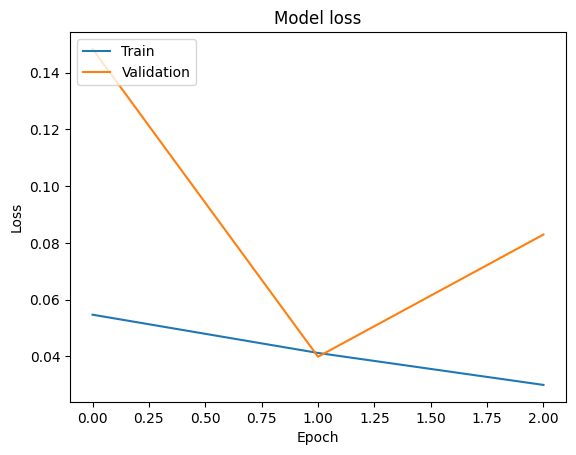

In [17]:
import matplotlib.pyplot as plt
try:
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
except:
    print('No history to plot')

In [ ]:
# def prepare_forecast_input(df, time_steps, num_items):
#     #df_test starts at 1942-7 which we need take into account
#     # Prepare input data for forecasting
#     forecast_input = []
#     for target_day in range(28):
#         start_idx = target_day * num_items
#         end_idx = start_idx + time_steps * num_items
#         sequence = df.iloc[start_idx:end_idx].drop('sales_amount', axis=1).to_numpy()
#         forecast_input.append(sequence)
#     return np.array(forecast_input)


# Custom function for input to prepare forecasts input for model
# def prepare_forecast_input(df, target, model, time_steps, num_items):
#     forecast_output = []
#     for target_day in range(28):
#         start_idx = target_day * num_items
#         end_idx = start_idx + time_steps * num_items
#         sequence = df.iloc[start_idx:end_idx, : ].drop(target, axis=1).to_numpy()
#         # forecast_output.append(model.predict(sequence))
#         forecast_output.append(model.predict(sequence.reshape(1, sequence.shape[0], sequence.shape[1])))
#     return np.array(forecast_output)#.reshape(-1, 1)
# forecast_output = prepare_forecast_input(df_test, target_col, model, time_steps, NUM_ITEMS)
#forecasts_original = scaler.inverse_transform(forecast_output)



In [ ]:
# Assuming df_all_data contains all data up to day 1941
# forecast_input = prepare_forecast_input(df_test, time_steps, NUM_ITEMS)

# Generate forecasts
# forecasts = model.predict(forecast_input)
# forecasts_original = scaler.inverse_transform(forecasts)

# forecasts_original now contains the predicted sales amounts for days 1942 to 1969


In [18]:
# Prepare input for forecasts
# I cannot use the custom lstm_data_generator
# Prepare 7 day slices each shifted by one day
def prepare_forecast_input(df, time_steps, target_col):
    forecast_input = []
    for i in range(0, len(df)//NUM_ITEMS): #i=0; 1, 2, 3, ..., 35?
        if i + time_steps < (len(df)-1)//NUM_ITEMS: #7, 8, 9, 10, ...
            start_idx = i*NUM_ITEMS
            end_idx   = start_idx + NUM_ITEMS * time_steps
            sequence  = df.iloc[start_idx : end_idx, :].drop(target_col, axis=1).to_numpy()
            forecast_input.append(sequence)
    return np.array(forecast_input)

predict_array = prepare_forecast_input(df=df_test, time_steps=time_steps, target_col=target_col)

In [19]:
predict_array.shape

(27, 213430, 20)

In [21]:
forecast_normalized = model.predict(predict_array)

1/1 [==============================] - 4s 4s/step


In [24]:
forecasts_original = scaler.inverse_transform(forecast_normalized)

In [26]:
forecasts_original.shape

(27, 1)

In [ ]:
# Now, let's define a function to calculate WRMSSE by calculating the RMSSE for each series and then multiplying by the weights and summing them up. 
def calculate_weights(sales_data, last_n_days=28):
    # sales_data: DataFrame with columns ['item_id', 'day', 'sales']
    # Sum sales for each item over the last_n_days
    item_sales = sales_data[sales_data['day'] > sales_data['day'].max() - last_n_days].groupby('item_id')['sales'].sum()
    # Total sales for all items
    total_sales = item_sales.sum()
    # Calculate weights
    weights = item_sales / total_sales
    return weights

def rmsse(y_true, y_pred, h, y_train):
    numerator = np.sum((y_true - y_pred) ** 2) / h
    denominator = np.sum(np.diff(y_train) ** 2) / (len(y_train) - 1) # np.diff to calc the diff for consecutive elements
    return np.sqrt(numerator / denominator)

def wrmsse(y_trues, y_preds, weights, h, y_trains):
    rmsse_values = [rmsse(y_true, y_pred, h, y_train) for y_true, y_pred, y_train in zip(y_trues, y_preds, y_trains)]
    return np.sum(np.array(weights) * np.array(rmsse_values))

In [ ]:
# Evaluate the model on the test set
def evaluate_model_wrmsse(model, df_test, df_train, df_val, batch_size, time_steps, n):
    test_gen = lstm_data_generator(df_test, target_col, time_steps, batch_size)
    steps = max(1, len(df_test) // (batch_size * n))  # Ensure at least 1 step
    y_pred_normalized = model.predict(test_gen, steps=steps)
    y_pred_original = scaler.inverse_transform(y_pred_normalized)
    y_true_normalized = df_test[target_col].values
    y_true_original = scaler.inverse_transform(y_true_normalized)
    
    #First concatenate all elements used for training (df_train and df_val)
    y_train_all_normalized = pd.concat([df_train[target_col], df_val[target_col]], axis=0).values
    y_train_all_original = scaler.inverse_transform(y_train_all_normalized)
    
    # Reshape the predictions and actuals to separate each item's time series
    y_pred_series = [y_pred_original[i::NUM_ITEMS] for i in range(NUM_ITEMS)]
    y_true_series = [y_true_original[i::NUM_ITEMS] for i in range(NUM_ITEMS)]

    # Similarly reshape the training data for RMSSE calculation
    y_train_all_series = [y_train_all_original[i::NUM_ITEMS] for i in range(NUM_ITEMS)]

    # Check - can be deleted later on
    print('len y_pred_series: ' + len(y_pred_series))
    print('len y_true_series: ' + len(y_true_series))
    print('len y_train_all_series: ' + len(y_train_all_series))
    
    # Calculate WRMSSE
    weights = calculate_weights(sales_data)
    wrmsse_score = wrmsse(y_trues=y_true_series, y_preds=y_pred_series, weights=weights, h=28, y_trains=y_train_all_series)

    print("Test WRMSSE: ", wrmsse_score)
    
    
    
    
    
    
    
    
    
    # Calculate wrmsse score
    wrmsse_score = wrmsse(
        y_trues=y_true_original,
        y_preds=y_pred_original,
        weights=calculate_weights(sales_data),
        h=28, # forecast horizon
        y_train=y_train_all_original
    )
    print("Test WRMSSE: ", wrmsse_score)

In [ ]:
# Call the evaluate function
# evaluate_model_wrmsse(model, df_test, df_train, df_val, batch_size, time_steps, VAL_END)